In [36]:
from typing import List
import random
import math
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [37]:
class MLP:
    def __init__(self, npl: List[int]): # neurons per layer, d in the slides
        self.npl = list(npl)
        self.L = len(npl)-1  # last layer index
        self.W = []  # weights weight of layer l going from neuron i to neuron j: W[l][i][j]

        for l in range(self.L + 1):
            self.W.append([])
            if (l == 0) : continue # no weights for input layer, to be consistent with indexing (W[1] are weights going to layer 1)

            for i in range(0, self.npl[l-1]+1): # +1 for bias neuron
                self.W[l].append([])
                for j in range(0, self.npl[l]+1):
                    rdm_value = random.random() * 2 - 1  # random value between -1 and 1
                    self.W[l][i].append(0.0 if j == 0 else rdm_value) # no weights going to bias neuron so set to 0.0 if j == 0 corresponds to bias neuron

        self.X = []  # activations of layer l neuron i: X[l][i]
        self.deltas = []  # deltas of layer l neuron i: deltas[l][i]

        for l in range(self.L + 1):
            self.X.append([])
            self.deltas.append([])

            for j in range(0, self.npl[l] + 1):
                self.X[l].append(1.0 if j==0 else 0.0)
                self.deltas[l].append(0.0)

    def _propagate(self, inputs: List[float], is_classification: bool):
        assert(len(inputs) == self.npl[0]) # check if inputs is the same size as nbs of layers

        # update first layer
        for j in range(len(inputs)):
            self.X[0][j + 1] = inputs[j] # update X for input (layer 0) and keep the weight

        # update all layers until output
        for l in range(1, self.L + 1):
            for j in range(1, self.npl[l]+1):
                signal = 0.0
                for i in range(0, self.npl[l-1] + 1):
                    signal += self.W[l][i][j] * self.X[l - 1][i]
                if (is_classification or l != self.L):
                    self.X[l][j] = math.tanh(signal)
                else:
                    self.X[l][j] = signal # use identity method only when regression and updating last layer

    def predict(self, inputs: List[float], is_classification: bool):
        self._propagate(inputs, is_classification)
        return self.X[self.L][1:]
    
    def train(self,
              all_samples_inputs: List[List[float]],
              all_samples_expected_outputs: List[List[float]],
              is_classification: bool,
              num_iter: int,
              alpha: float):
        
        assert(len(all_samples_inputs) == len(all_samples_expected_outputs))
        for _ in tqdm(range(num_iter)):
            k = random.randint(0, len(all_samples_inputs) - 1)
            inputs_k = all_samples_inputs[k]
            labels_k = all_samples_expected_outputs[k]

            self._propagate(inputs_k, is_classification) # mise à jour des sorties de tous les neurons (self.X)

            for j in range(1, self.npl[self.L] + 1): # start with 1 to avoid last layer 1
                self.deltas[self.L][j] = (self.X[self.L][j] - labels_k[j-1])
                if (is_classification) :
                    self.deltas[self.L][j] *= (1.0 - self.X[self.L][j]**2)

            # get the deltas
            for l in reversed(range(2, self.L + 1)):
                for i in range(1, self.npl[l-1] + 1):
                    total = 0.0
                    for j in range(1, self.npl[l] + 1):
                        total += self.W[l][i][j] * self.deltas[l][j]
                    total *= (1.0 - self.X[l-1][i] ** 2)
                    self.deltas[l-1][i] = total

            # update weights
            for l in range(1, self.L + 1):
                for i in range(0, self.npl[l-1] + 1):
                    for j in range(1, self.npl[l] + 1):
                        self.W[l][i][j] -= alpha*self.X[l-1][i]*self.deltas[l][j]

In [38]:
mlp = MLP([2, 3, 1])
print(mlp.X)
print(mlp.W)
print(mlp.deltas)

[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [1.0, 0.0]]
[[], [[0.0, 0.5310829884772206, -0.5276628931890259, 0.054597771206222445], [0.0, -0.2953089326348983, -0.7421513763758418, -0.8262347885388837], [0.0, 0.17699240377811165, 0.5699946350496508, 0.6377449282625245]], [[0.0, 0.7835549951662608], [0.0, 0.8226082839211777], [0.0, -0.8988066933863785], [0.0, -0.4226133208330429]]]
[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0]]


In [39]:
mlp.predict([42.0, 53.0], True)

[0.791384901570766]

In [40]:
xor_inputs = [
    [0.0, 0.0],
    [1.0, 0.0],
    [0.0, 1.0],
    [1.0, 1.0]
]

xor_expected_ouputs = [
    [-1.0],
    [1.0],
    [1.0],
    [-1.0]
]

for inp in xor_inputs:
    print(mlp.predict(inp, True))
mlp.train(xor_inputs, xor_expected_ouputs, True, 100000, 0.01)

for inp in xor_inputs:
    print(mlp.predict(inp, True))

[0.9209305970826861]
[0.9650821541906326]
[0.7588648737906705]
[0.935957077932033]


100%|██████████| 100000/100000 [00:01<00:00, 87872.71it/s]

[-0.9795304013534794]
[0.9751404438473329]
[0.9750233883951657]
[-0.9822344254308635]


In [123]:
class MLP_matrix:
    def __init__(self, npl: List[int]): # neurons per layer, d in the slides
        self.npl = list(npl)
        self.L = len(npl)-1  # last layer index
        # weights weight of layer l going from neuron i to neuron j: W[l][i][j]
        self.W = []
        self.W.append(np.array([]))  # no weights for input layer, to be consistent with indexing (W[1] are weights going to layer 1)

        for l in range(1, self.L + 1):
            self.W.append(np.random.uniform(-1, 1, (self.npl[l-1]+1, self.npl[l]+1)))  # +1 for bias neuron from layer l-1 to layer l
            self.W[l][ :, 0] = 0.0  # no weights going to bias neuron so set to 0.0, j == 0 corresponds to bias neuron

        self.X = []  # activations of layer l neuron i: X[l][i]
        self.deltas = []  # deltas of layer l neuron i: deltas[l][i]

        for l in range(self.L + 1):
            self.X.append(np.zeros((self.npl[l] + 1, 1)))
            self.X[l][0][0] = 1.0  # bias neuron

            self.deltas.append(np.zeros((self.npl[l] + 1, 1)))

    def _propagate(self, inputs: np.ndarray, is_classification: bool):
        assert(len(inputs) == self.npl[0]) # check if inputs is the same size as nbs of layers

        self.X[0][1:] = inputs # update the X row vector for input layer (keeping bias neuron)

        # update all layers until output
        for l in range(1, self.L + 1):
            signal = self.W[l].T @ self.X[l - 1]  # matrix multiplication

            if (is_classification or l != self.L):
                self.X[l] = np.tanh(signal)
            else:
                self.X[l] = signal # use identity method only when regression and updating last layer

    def predict(self, inputs: np.ndarray, is_classification: bool):
        self._propagate(inputs, is_classification)
        return self.X[self.L][1:]
    
    def train(self,
              X: np.ndarray,
              Y: np.ndarray,
              is_classification: bool,
              num_iter: int,
              alpha: float):
        
        assert(X.shape[1] == Y.shape[1])

        MSE = np.zeros((num_iter//100-1,))
        error = 0

        for i in tqdm(range(num_iter)):
            k = np.random.randint(0, X.shape[1]) # pick a random sample
            X_k = X[:,k].reshape(-1, 1) # get the k-th sample as a column vector
            Y_k = np.ones((Y.shape[0]+1, 1))
            Y_k[1:] = Y[:,k].reshape(-1, 1) # add bias neuron at index 0 (easy to handle with matrix operations)

            self._propagate(X_k, is_classification) # mise à jour des sorties de tous les neurons (self.X)

            self.deltas[self.L] = self.X[self.L] - Y_k

            error += np.mean(self.deltas[self.L]**2)
            if i % 100 == 0 and i > 0:
                MSE[i//100-1] = error / 100.0
                error = 0

            if is_classification:
                self.deltas[self.L] *= (1.0 - self.X[self.L]**2) # square element wise

            # get the deltas
            for l in reversed(range(2, self.L + 1)):
                self.deltas[l-1] = (1.0 - self.X[l-1]**2) * (self.W[l] @ self.deltas[l])

            # update weights
            for l in range(1, self.L + 1):
                self.W[l] -= alpha*self.X[l-1]*self.deltas[l].T

        return MSE

In [124]:
mlp_mat = MLP_matrix([2, 2, 1])
print(mlp_mat.X)
print(mlp_mat.W)
print(mlp_mat.deltas)

[array([[1.],
       [0.],
       [0.]]), array([[1.],
       [0.],
       [0.]]), array([[1.],
       [0.]])]
[array([], dtype=float64), array([[ 0.        , -0.43944957,  0.97221964],
       [ 0.        ,  0.72950835,  0.83697776],
       [ 0.        , -0.23793967, -0.17807134]]), array([[ 0.        , -0.91616351],
       [ 0.        , -0.01676433],
       [ 0.        , -0.35276305]])]
[array([[0.],
       [0.],
       [0.]]), array([[0.],
       [0.],
       [0.]]), array([[0.],
       [0.]])]


In [125]:
mlp_mat.predict(np.array([[42.0], [53.0]]), True)

array([[-0.35357825]])

In [126]:
xor_inputs = np.array([
    [0.0, 1.0, 0.0, 1.0],
    [0.0, 0.0, 1.0, 1.0],
])

xor_expected_ouputs =np.array([
    [-1.0, 1.0, 1.0,-1.0]
])

for col in range(xor_inputs.shape[1]):
    inp = xor_inputs[:, col].reshape(-1, 1)
    print(mlp_mat.predict(inp, True))
mlp_mat.train(xor_inputs, xor_expected_ouputs, True, 100000, 0.01)

for col in range(xor_inputs.shape[1]):
    inp = xor_inputs[:, col].reshape(-1, 1)
    print(mlp_mat.predict(inp, True))

[[-0.25198559]]
[[-0.3266397]]
[[-0.21956704]]
[[-0.31637142]]


100%|██████████| 100000/100000 [00:04<00:00, 20894.35it/s]

[[-0.98722634]]
[[0.97541503]]
[[0.97577099]]
[[-0.97597862]]


100%|██████████| 10000/10000 [00:00<00:00, 32323.78it/s]


[[0.96315016]]
[[-0.97711235]]
[[-0.99148725]]


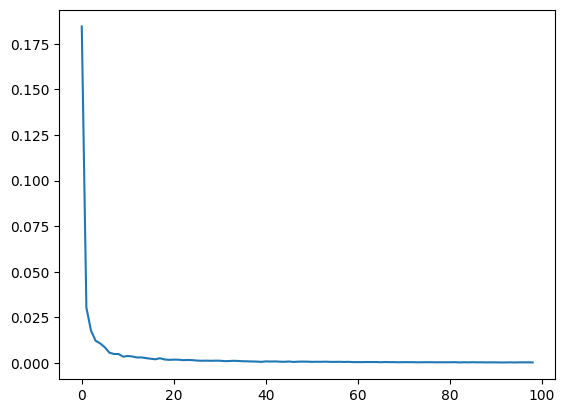

In [127]:
mlp_mat = MLP_matrix([2, 1])

X = np.array([
      [1, 1],
      [2, 3],
      [3, 3]
])
Y = np.array([[
      1,
      -1,
      -1
]])

error = mlp_mat.train(X.T, Y, True, 10000, 0.1)

plt.plot(error)

for i in range(X.shape[0]):
    inp = X[i].reshape(-1, 1)
    print(mlp_mat.predict(inp, True))

(100, 2)
(100, 1)


100%|██████████| 100000/100000 [00:03<00:00, 32600.10it/s]


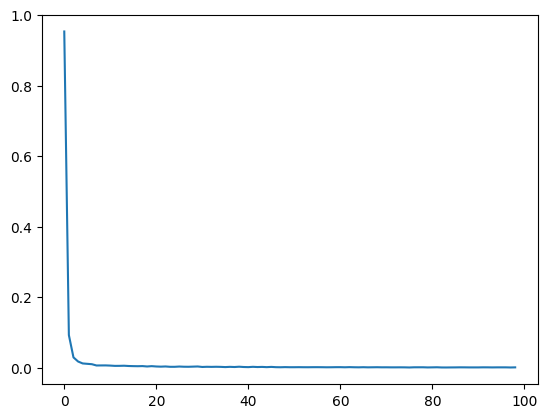

[[0.99318782]]
[[0.99998283]]
[[0.78625898]]
[[0.97559167]]
[[0.99648582]]
[[0.96818248]]
[[0.99999446]]
[[0.99999188]]
[[0.99850011]]
[[0.99316891]]
[[0.98071468]]
[[0.99913027]]
[[0.98817236]]
[[0.99806355]]
[[0.997727]]
[[0.85590298]]
[[0.99807247]]
[[0.99926993]]
[[0.99984096]]
[[0.99681553]]
[[0.99863609]]
[[0.95284115]]
[[0.99873258]]
[[0.98468649]]
[[0.9999504]]
[[0.99768263]]
[[0.99909687]]
[[0.99729228]]
[[0.99978818]]
[[0.99998179]]
[[0.99991115]]
[[0.9999747]]
[[0.99604814]]
[[0.99800869]]
[[0.93947835]]
[[0.9949376]]
[[0.99895103]]
[[0.99432366]]
[[0.99923464]]
[[0.99115333]]
[[0.92461916]]
[[0.99969831]]
[[0.99918913]]
[[0.93548188]]
[[0.99896531]]
[[0.99173192]]
[[0.99867497]]
[[0.99924196]]
[[0.986759]]
[[0.99955835]]
[[-0.94349476]]
[[-0.99995276]]
[[-0.99993054]]
[[-0.72984252]]
[[-0.99984924]]
[[-0.96531791]]
[[-0.99928039]]
[[-0.9986283]]
[[-0.99995464]]
[[-0.99999383]]
[[-0.99826048]]
[[-0.99313827]]
[[-0.99967842]]
[[-0.99999386]]
[[-0.99233297]]
[[-0.99852447]]
[[

In [100]:
mlp_mat = MLP_matrix([2, 1])

X = np.concatenate([np.random.random((50,2)) * 0.9 + np.array([1, 1]), np.random.random((50,2)) * 0.9 + np.array([2, 2])])
Y = np.concatenate([np.ones((50, 1)), np.ones((50, 1)) * -1.0])

print(X.shape)
print(Y.shape)

error = mlp_mat.train(X.T, Y.T, True, 100000, 0.1)

plt.plot(error)
plt.show()

for i in range(X.shape[0]):
    inp = X[i].reshape(-1, 1)
    print(mlp_mat.predict(inp, True))

(500, 2)
(500, 1)


100%|██████████| 200000/200000 [00:13<00:00, 15356.75it/s]


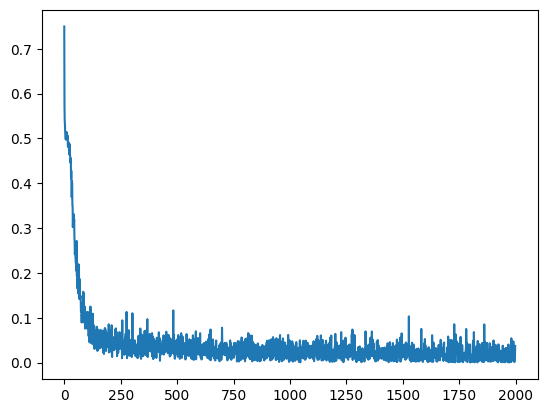

In [120]:
mlp_mat = MLP_matrix([2, 6, 4, 1])

X = np.random.random((500, 2)) * 2.0 - 1.0
Y = np.array([1 if abs(p[0]) <= 0.3 or abs(p[1]) <= 0.3 else -1 for p in X]).reshape(-1, 1)

print(X.shape)
print(Y.shape)

error = mlp_mat.train(X.T, Y.T, True, 200000, 0.01)

plt.plot(error)
plt.show()


(412, 2)
(412, 3)


100%|██████████| 10000/10000 [00:00<00:00, 33799.41it/s]


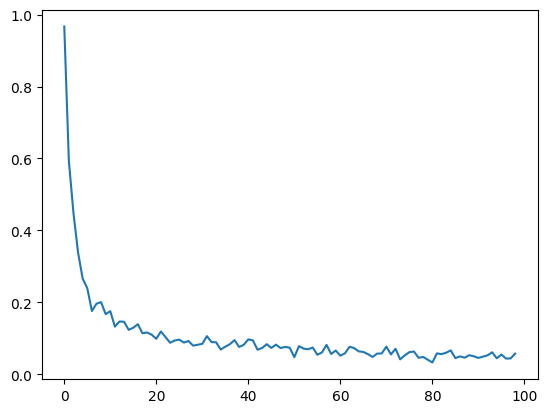

In [129]:
mlp_mat = MLP_matrix([2, 3])

X = np.random.random((500, 2)) * 2.0 - 1.0
Y = np.array([[1, -1, -1] if -p[0] - p[1] - 0.5 > 0 and p[1] < 0 and p[0] - p[1] - 0.5 < 0 else
              [-1, 1, -1] if -p[0] - p[1] - 0.5 < 0 and p[1] > 0 and p[0] - p[1] - 0.5 < 0 else
              [-1, -1, 1] if -p[0] - p[1] - 0.5 < 0 and p[1] < 0 and p[0] - p[1] - 0.5 > 0 else
              [-1, -1, -1]for p in X])

X = X[[not np.all(arr == [-1, -1, -1]) for arr in Y]]
Y = Y[[not np.all(arr == [-1, -1, -1]) for arr in Y]]



print(X.shape)
print(Y.shape)

error = mlp_mat.train(X.T, Y.T, True, 10000, 0.01)

plt.plot(error)
plt.show()

(1000, 2)
(1000, 3)


100%|██████████| 1000000/1000000 [01:05<00:00, 15327.78it/s]


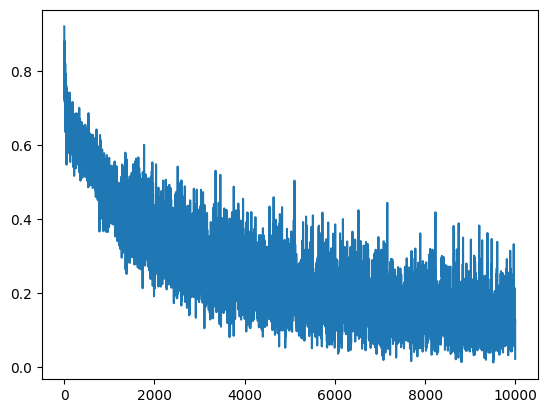

In [164]:
mlp_mat = MLP_matrix([2, 32, 24, 3])

X = np.random.random((1000, 2)) * 2.0 - 1.0
Y = np.array([[1, -1, -1] if abs(p[0] % 0.5) <= 0.25 and abs(p[1] % 0.5) > 0.25 else [-1, 1, -1] if abs(p[0] % 0.5) > 0.25 and abs(p[1] % 0.5) <= 0.25 else [-1, -1, 1] for p in X])

print(X.shape)
print(Y.shape)

error = mlp_mat.train(X.T, Y.T, True, 1000000, 0.03)

plt.plot(error)
plt.show()

(2, 1)
(2, 1)


100%|██████████| 1000/1000 [00:00<00:00, 24948.13it/s]


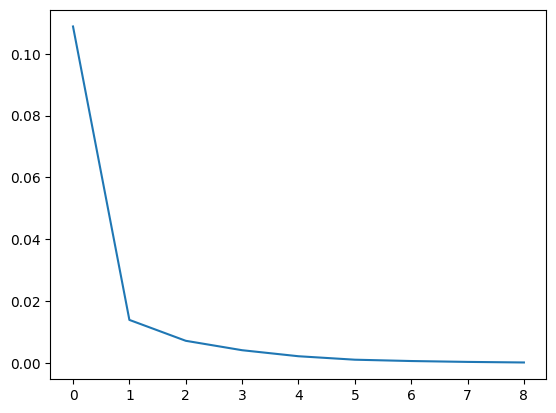

In [178]:
mlp_mat = MLP_matrix([1,1])

X = np.array([
      [1],
      [2]
])
Y = np.array([
      2,
      3
]).reshape(-1, 1)

print(X.shape)
print(Y.shape)

error = mlp_mat.train(X.T, Y.T, False, 1000, 0.04)

plt.plot(error)
plt.show()

In [ ]:
mlp_mat = MLP_matrix([1,1])

X = np.array([
      [1],
      [2]
])
Y = np.array([
      2,
      3
]).reshape(-1, 1)

print(X.shape)
print(Y.shape)

error = mlp_mat.train(X.T, Y.T, False, 1000, 0.04)

plt.plot(error)
plt.show()

# TODO
- tester avec régression
- implem en C++
- implémenter recorder